# Shallow Water Equation

## Load packages

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from utils import *


## Solve the 1D SWE using the Finite Volume Method with a Riemann solver



## First attempt

In [46]:
# Implement the Riemann solver
def roe_solver(hL, huL, hR, huR, g=9.81):
    # Calculate Roe averages
    h_tilde = (hL + hR) / 2
    u_tilde = (np.sqrt(hL) * huL / hL + np.sqrt(hR) * huR / hR) / (np.sqrt(hL) + np.sqrt(hR))

    c = np.sqrt(g * h_tilde)

    # Calculate eigenvalues
    lambda1 = u_tilde - c
    lambda2 = u_tilde + c

    # Compute fluxes
    F_L = np.array([huL, huL**2 / hL + 0.5 * g * hL**2])
    F_R = np.array([huR, huR**2 / hR + 0.5 * g * hR**2])

    # Difference 
    dU = np.array([hR - hL, huR - huL])

    # Compute Roe flux
    if lambda1 >= 0 and lambda2 >= 0:
        return F_L
    elif lambda1 < 0 and lambda2 > 0:
        return 0.5 * (F_L + F_R) - 0.5* c * dU
    else:
        return F_R
    

# Calculate the flux at each interface
def compute_interface_fluxes(h, hu, N):
    fluxes = np.zeros((2, N+1))
    for i in range(1,N):
        fluxes[:,i] = roe_solver(h[i-1], hu[i-1], h[i], hu[i])
    return fluxes

# Time integration
def update_variables(h, hu, dt, fluxes, N, dx):
    for i in range(1, N-1):
        h[i] = h[i] - dt/dx * (fluxes[0, i+1] - fluxes[0, i])
        hu[i] = hu[i] - dt/dx * (fluxes[1, i+1] - fluxes[1, i])
    return h, hu

In [47]:
# Function to visualize
def subplot(h_hist,idx, L, N, save):
    idx1,idx2,idx3 = idx
    plt.figure(figsize=(17,5))
    plt.subplot(1,3,1)
    plt.plot(np.linspace(0, L, N), h_hist[idx1])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx1}/{len(h_hist) - 1}')

    plt.subplot(1,3,2)
    plt.plot(np.linspace(0, L, N), h_hist[idx2])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx2}/{len(h_hist) - 1}')

    plt.subplot(1,3,3)
    plt.plot(np.linspace(0, L, N), h_hist[idx3])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx3}/{len(h_hist) - 1}')

    if save:
        plt.savefig(f'VSC/tex/plots/subplot_{idx1}.png')

    plt.show()
    return


Number of time steps:
113


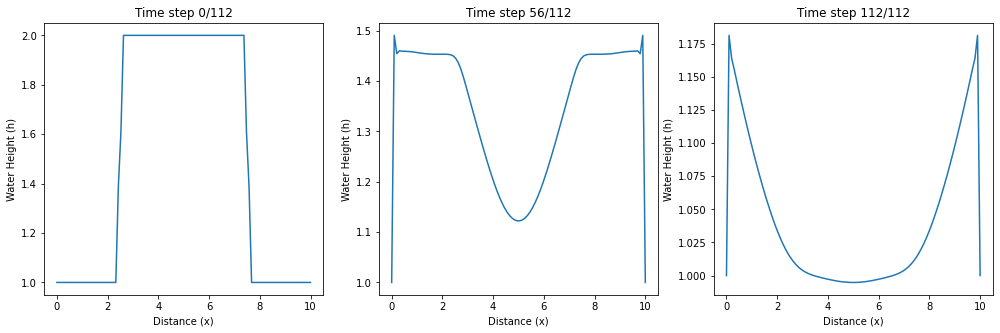

In [48]:
# Initialization
N = 100 # Number of grid points
L = 10 # Length of the domain
dx = L / N

CFL = 0.9 # CFL number
g = 9.81 # Gravity


# Initial conditions
h = np.ones(N)
hu = np.zeros(N)
u = np.zeros(N)

h[int(N/4):int(3*N/4)] = 2.0  # higher water level in the middle

t = 0
t_end = 2

# Store the intermediate states
h_hist = []
dt_hist = []
flux_hist = []

# Main loop
while t < t_end:
    # Compute time step size 
    u = hu/h
    c = np.sqrt(g*h)
    dt = CFL * dx/ np.max(np.abs(u) + c)

    if t + dt > t_end:
        dt = t_end - t
    
    # Compute fluxes at interfaces
    fluxes = compute_interface_fluxes(h, hu, N)
    
    # Update variables
    h, hu = update_variables(h, hu, dt, fluxes, N, dx)
    h_hist.append(h.copy())
    dt_hist.append(dt)
    flux_hist.append(fluxes.copy())
    
    t += dt

n = len(dt_hist)

print('Number of time steps:')
print(n)

# Make 3 subplots
idx = [0,int(n/2),n-1]
#idx = [0, 30, 60]
subplot(h_hist,idx, L, N, save=False)
#idx = [90, 120, 200]
#subplot(h_hist,idx, L, N, save=False)


Max difference between initial and final state:
1.0051410888997179
Max difference between each time step:
0.2877285418161757
Sum of differences between each time step:
1.6856130968552572


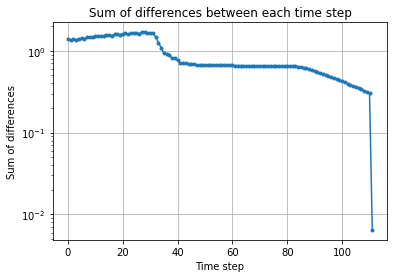

In [49]:
h_hist = np.array(h_hist)
h_hist.shape
# Calculate the difference between the initial and final state
diff = np.abs(h_hist[0] - h_hist[-1])
print('Max difference between initial and final state:')
print(np.max(diff))

# Calculate the difference between each time steps
diff = np.abs(h_hist[1:] - h_hist[:-1])
print('Max difference between each time step:')
print(np.max(diff))
diff.shape

# Sum each row and plot per time step
sum_diff = np.sum(diff, axis=1)
print('Sum of differences between each time step:')
print(np.max(sum_diff))

plt.semilogy(sum_diff,'.-')
plt.xlabel('Time step')
plt.ylabel('Sum of differences')
plt.grid()
plt.title('Sum of differences between each time step')
plt.show()


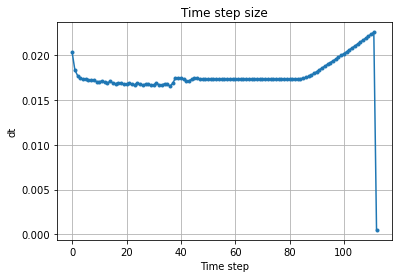

In [50]:
plt.plot(dt_hist,'.-')
plt.title('Time step size')
plt.xlabel('Time step')
plt.ylabel('dt')
plt.grid()
plt.show()

In [51]:
# Create animation
if 0:
    fig, ax = plt.subplots(figsize=(10,6))

    def update_plot(index):
        ax.clear()
        ax.plot(np.linspace(0, L, N), h_hist[index])
        ax.set_xlabel('Distance (x)')
        ax.set_ylabel('Water Height (h)')
        ax.set_title(f'Time step {index}/{len(h_hist) - 1}')

    ani = animation.FuncAnimation(fig, update_plot, frames=len(h_hist), interval=100)
    #ani.save('animation.html', writer='html')
    #from PIL import Image
    #dpi = 200
    #ani.save('animation.gif', writer='pillow', dpi = dpi)

    # Display the animation
    from IPython.display import HTML
    #from PIL import Image
    HTML(ani.to_jshtml())

### Boundary conditions

In [52]:
def subplot(h_hist, idx, L, N,save):
    idx1, idx2, idx3 = idx
    y_max = max([h_hist[i].max() for i in idx]) + 0.1 # Determine the maximum y value among the selected indices
    y_min = min([h_hist[i].min() for i in idx]) - 0.1 # Determine the minimum y value among the selected indices

    plt.figure(figsize=(17, 5))

    plt.subplot(1, 3, 1)
    plt.plot(np.linspace(0, L, N), h_hist[idx1])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx1}/{len(h_hist) - 1}')
    plt.ylim(y_min, y_max)

    plt.subplot(1, 3, 2)
    plt.plot(np.linspace(0, L, N), h_hist[idx2])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx2}/{len(h_hist) - 1}')
    plt.ylim(y_min, y_max)

    plt.subplot(1, 3, 3)
    plt.plot(np.linspace(0, L, N), h_hist[idx3])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx3}/{len(h_hist) - 1}')
    plt.ylim(y_min, y_max)



Number of time steps: 502


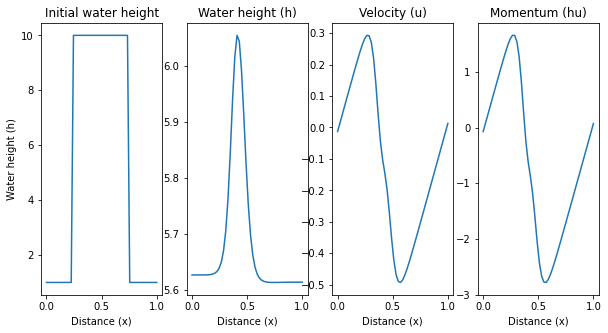

In [65]:
# Initialization
N = 50 # Number of grid points
L = 1 # Length of the domain
dx = L / N
x = np.linspace(0, L, N)

CFL = 0.9 # CFL number
g = 9.81 # Gravity


# Initial conditions
h = np.ones(N)
hu = np.zeros(N)
u = np.zeros(N)

h[int(N/4):int(3*N/4)] = 10.0  # higher water level in the middle

t = 0
t_end = 1

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, lim_func = no_limiter, CFL=0.9,g=9.81)

subplot_solution(x, h, hu, h_hist, save=False, filename='VSC/tex/plots/solution.png')


In [41]:
if 0:    
    fig, ax = plt.subplots(figsize=(10, 6))

    def update_plot(index):
        ax.clear()
        ax.plot(np.linspace(0, L, N), h_hist[index])
        ax.set_xlabel('Distance (x)')
        ax.set_ylabel('Water Height (h)')
        ax.set_title(f'Time step {index}/{len(h_hist) - 1}')
        ax.set_ylim(0, 10)  # Adjust this based on the expected range of water height
        ax.set_xlim(0, L)     # Ensure x-axis limits are consistent


    ani = animation.FuncAnimation(fig, update_plot, frames=len(h_hist), interval=100)

    # Display the animation
    HTML(ani.to_jshtml())

    #ani.save('animation.html', writer='html')


In [42]:
#ani.save('animation_bc_short_2.html', writer='html')
#dpi = 200
#ani.save('animation_bc.gif', writer='pillow', dpi = dpi)

## Validate with solution

### No limiter

Number of time steps: 84


ValueError: x and y must have same first dimension, but have shapes (200,) and (50,)

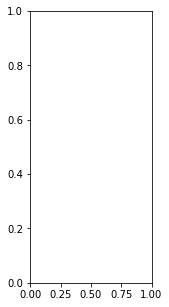

In [45]:
# Initialization
N = 200 # Number of grid points
L = 50 # Length of the domain
dx = L / N

# Initial conditions
l = 2*np.pi
A = 1
T = 2*np.pi
omega = 2*np.pi/T
k = 2*np.pi/l
g = 9.81
h0 = omega**2/(k**2*g)

x = np.linspace(0, L, N)

hl = 3.5
hr = 1.25
h = np.where(x < 20, hl, hr)
hu = np.zeros(N)
u = np.zeros(N)

t = 0
t_end = 2.5

def eta_func(x,t):
    return A*np.cos(omega*t - k*x)

def u_func(x,t):
    return omega/(k*h0)*eta_func(x,t)

def no_limiter(a, b):
    return 0

h, hu, hu_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, lim_func = no_limiter, CFL=0.9,g=9.81)

# Make 4 subplots
subplot_solution(x, h, hu, h_hist, save=False, filename='VSC/tex/plots/solution.png')


### Add limiter

In [ ]:
# Initialization
N = 200 # Number of grid points
L = 50 # Length of the domain
dx = L / N

# Initial conditions
l = 2*np.pi
A = 1
T = 2*np.pi
omega = 2*np.pi/T
k = 2*np.pi/l
g = 9.81
h0 = omega**2/(k**2*g)

x = np.linspace(0, L, N)

hl = 3.5
hr = 1.25
h = np.where(x < 20, hl, hr)
hu = np.zeros(N)
u = np.zeros(N)

t = 0
t_end = 2.5

def no_limiter(a, b):
    return 0

h, hu, hu_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, lim_func = minmod, CFL=0.9,g=9.81)

# Make 4 subplots
subplot_solution(x, h, hu, h_hist, save=False, filename='VSC/tex/plots/solution.png')


Test: 79
Number of time steps: 79


ValueError: not enough values to unpack (expected 3, got 2)

## Pyro SWE

In [ ]:
#pip install pyro-hydro

## Solve the 2D SWE

In [ ]:
# Initialization
N = 100 # Number of grid points
L = 10 # Length of the domain
dx = L / N

CFL = 0.9 # CFL number
g = 9.81 # Gravity


# Initial conditions
h = np.ones(N)
q = np.zeros(N)
r = np.zeros(N)

h[int(N/4):int(3*N/4)] = 2.0  # higher water level in the middle


## Bras